In [1]:
import numpy as np 
import pandas as pd 
import os


In [2]:
from keras.applications import MobileNet



Using TensorFlow backend.


In [3]:
img_rows, img_cols = 224, 224
MobileNet = MobileNet(weights = 'imagenet',
                     input_shape = (img_rows, img_cols, 3),
                     include_top = False)


In [4]:
# Layers are set to trainable as True by default
for layer in MobileNet.layers:
    layer.trainable = False


In [5]:
# Let's print our layers 
for (i,layer) in enumerate(MobileNet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

('0 InputLayer', False)
('1 ZeroPadding2D', False)
('2 Conv2D', False)
('3 BatchNormalization', False)
('4 ReLU', False)
('5 DepthwiseConv2D', False)
('6 BatchNormalization', False)
('7 ReLU', False)
('8 Conv2D', False)
('9 BatchNormalization', False)
('10 ReLU', False)
('11 ZeroPadding2D', False)
('12 DepthwiseConv2D', False)
('13 BatchNormalization', False)
('14 ReLU', False)
('15 Conv2D', False)
('16 BatchNormalization', False)
('17 ReLU', False)
('18 DepthwiseConv2D', False)
('19 BatchNormalization', False)
('20 ReLU', False)
('21 Conv2D', False)
('22 BatchNormalization', False)
('23 ReLU', False)
('24 ZeroPadding2D', False)
('25 DepthwiseConv2D', False)
('26 BatchNormalization', False)
('27 ReLU', False)
('28 Conv2D', False)
('29 BatchNormalization', False)
('30 ReLU', False)
('31 DepthwiseConv2D', False)
('32 BatchNormalization', False)
('33 ReLU', False)
('34 Conv2D', False)
('35 BatchNormalization', False)
('36 ReLU', False)
('37 ZeroPadding2D', False)
('38 DepthwiseConv2D', Fa

In [6]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model


num_classes = 1

FC_Head = lw(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [8]:
from keras.preprocessing.image import ImageDataGenerator
import os

base_path = os.getcwd()
print(base_path)
validation_data_dir = './yogesh/test'
train_data_dir = './yogesh/train'
print(train_data_dir)

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

/home/bmkumar/Desktop/mlops/task3
./yogesh/train
Found 399 images belonging to 1 classes.
Found 201 images belonging to 1 classes.


In [9]:
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

                     
checkpoint = ModelCheckpoint("face_recog.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 399
nb_validation_samples = 201

# We only train 5 EPOCHS 
epochs = 1
batch_size = 5

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)


Epoch 1/1
79/79 [==============================] - 210s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


yogesh_572.jpg
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]


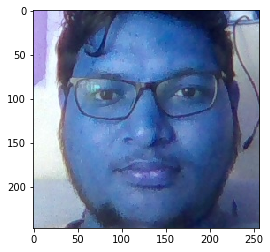

In [12]:
from matplotlib import pyplot as plt
import cv2
model.save("face_recog.h5")
directory = os.listdir("./yogesh/test/yogesh")
print(directory[111])

for i in range(10):
    myimage = cv2.imread("./yogesh/test/yogesh/" + directory[i])
    plt.imshow(myimage)

    myimage = cv2.resize(myimage, (img_rows,img_cols))
    myimage = myimage.reshape(1,img_rows,img_cols,3)

    pred = model.predict(myimage)
    print(pred)

#print(dir(model))
#print(model.__class__)